# Simulation using Concord

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scanpy as sc
import time
from pathlib import Path
import torch
import concord as ccd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl

from matplotlib import font_manager, rcParams
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42

In [3]:
proj_name = "simulation_trajectory_varybatch"
save_dir = f"../save/dev_{proj_name}-{time.strftime('%b%d')}/"
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = f"../data/{proj_name}/"
data_dir = Path(data_dir)
data_dir.mkdir(parents=True, exist_ok=True)
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(device)
seed = 0
ccd.ul.set_seed(seed)

file_suffix = f"{time.strftime('%b%d-%H%M')}"
file_suffix


cpu


'Jul29-2018'

In [4]:
concord_methods = ['concord_hcl', 'concord_knn']
other_methods = [
    'contrastive',
        "unintegrated",
        "scanorama", "liger", "harmony",
        "scvi", 
]
run_methods = concord_methods + other_methods
# exclude ["UMAP", "t-SNE"] from run_method, and save as combined_keys
exclude_keys = ["PCA", "UMAP", "t-SNE"]
combined_keys = ['no_noise', 'wt_noise'] + [key for key in run_methods if key not in exclude_keys]

In [5]:
state_key = 'time'
batch_key = 'batch'
state_type = 'trajectory'
distribution = 'normal'
batch_distribution = 'normal'
leiden_key = 'leiden_no_noise'

In [38]:
"""
Single‑trajectory benchmark in which every *pair* of batches has the same
batch‑effect type at two different strengths (“low” / “high”).  This version
uses **option 2**: EFFECT_SPEC is a list of (effect_type, spec‑dict) tuples,
so you can repeat the same effect type with different parameterisations
(e.g. different noise distributions).
"""

import numpy as np
import anndata as ad
from concord.simulation import (
    Simulation,
    SimConfig, TrajectoryConfig, BatchConfig
)

# ───────────────────────── USER‑TUNABLES ──────────────────────────
TOTAL_CELLS   = 4_000        # overall cells (evenly split by default)
TOTAL_GENES   = 2_000
SEED_STATE    = 42
SEED_BATCH    = 4_242

# Two‑element “level” lists ⇒ [low, high]
EFFECT_SPEC = [
    ("variance_inflation",
        dict(level=[1, 4])),                             # multiplicative
    ("batch_specific_distribution",
        dict(level=[1, 5], distribution="normal")),
    ("batch_specific_distribution",
        dict(level=[1, 5], distribution="negative_binomial")),
    ("uniform_dropout",
        dict(level=[0.1, 0.4])),
    # ("value_dependent_dropout",
    #     dict(level=[0.01, 0.05])),
    ("downsampling",
        dict(level=[0.2, 0.8])),
    ("scaling_factor",
        dict(level=[0.5, 2.0])),
    ("batch_specific_expression",
        dict(level=[5, 10], distribution="normal", feature_frac=0.10)),
    ("batch_specific_features",
        dict(level=[5, 10], distribution="normal", feature_frac=0.10)),
]

traj_cfg = TrajectoryConfig(
    # generic “state” parameters
    distribution   = "normal",   # ← state_distribution
    level          = 10,         # ← state_level
    min_level      = 0,          # ← state_min_level
    dispersion     = 6.0,        # ← state_dispersion

    # trajectory-specific knobs (copied 1-to-1)
    program_num            = 5,              # trajectory_program_num
    program_structure      = "linear_bidirectional",
    program_on_time_fraction = 0.2,
    cell_block_size_ratio  = 0.6,
    loop_to                = None,
)


# ─────────────── Build per‑batch parameter lists ──────────────────
n_effects  = len(EFFECT_SPEC)
rng        = np.random.default_rng(SEED_BATCH)

types, levels, dists, disps, f_fracs, cell_props, labels = (
    [], [], [], [], [], [], []
)

for eff, spec in EFFECT_SPEC:
    # two batches per effect type
    types.extend([eff, eff])

    # levels and other params
    lvl_low, lvl_high = spec.get("level", [None, None])
    levels.extend([lvl_low, lvl_high])

    dist = spec.get("distribution", "normal")
    dists.extend([dist, dist])

    disp = spec.get("dispersion", 2.0)
    disps.extend([disp, disp])

    ff = spec.get("feature_frac", 0.0)
    f_fracs.extend([ff, ff])

    # equal cell proportion by default
    cell_props.extend([1 / (2 * n_effects)] * 2)

    # human‑readable batch labels
    base = eff if eff != "batch_specific_distribution" else f"{eff}_{dist}"
    labels.extend([f"{base}_low", f"{base}_high"])

# ─────────────── Assemble BatchConfig ─────────────────────────────
batch_cfg = BatchConfig(
    n_batches       = len(types),
    effect_type     = types,
    distribution    = dists,
    level           = levels,
    dispersion      = disps,
    feature_frac    = f_fracs,
    cell_proportion = cell_props,
)

# ─────────────── Assemble SimConfig & run ────────────────────────
sim_cfg = SimConfig(
    n_cells = TOTAL_CELLS,
    n_genes = TOTAL_GENES,
    seed    = SEED_STATE,
    non_neg = True,
    to_int  = True,
)

sim = Simulation(sim_cfg, traj_cfg, batch_cfg)
adata, adata_state = sim.simulate_data()
adata.layers["counts"] = adata.X.copy()

# map descriptive labels to batches (order preserved)
adata.obs["batch_label"] = adata.obs["batch"].map(
    dict(zip(adata.obs["batch"].unique(), labels))
)
adata.obs['batch_type'] = adata.obs["batch"].map(
    dict(zip(adata.obs["batch"].unique(), types))
)

print(adata)


AnnData object with n_obs × n_vars = 4000 × 2400
    obs: 'time', 'batch', 'batch_id', 'batch_label', 'batch_type'
    layers: 'no_noise', 'wt_noise', 'counts'


In [39]:
import pandas as pd
pd.crosstab(adata.obs["batch"], adata.obs["batch_label"])

batch_label  batch_specific_distribution_negative_binomial_high  \
batch                                                             
batch_1                                                      0    
batch_10                                                     0    
batch_11                                                     0    
batch_12                                                     0    
batch_13                                                     0    
batch_14                                                     0    
batch_15                                                     0    
batch_16                                                     0    
batch_2                                                      0    
batch_3                                                      0    
batch_4                                                      0    
batch_5                                                      0    
batch_6                                                    250    
batch_7                                                      0    
batch_8                                                      0    
batch_9                                                      0    

batch_label  batch_specific_distribution_negative_binomial_low  \
batch                                                            
batch_1                                                      0   
batch_10                                                     0   
batch_11                                                     0   
batch_12                                                     0   
batch_13                                                     0   
batch_14                                                     0   
batch_15                                                     0   
batch_16                                                     0   
batch_2                                                      0   
batch_3                                                      0   
batch_4                                                      0   
batch_5                                                    250   
batch_6                                                      0   
batch_7                                                      0   
batch_8                                                      0   
batch_9                                                      0   

batch_label  batch_specific_distribution_normal_high  \
batch                                                  
batch_1                                            0   
batch_10                                           0   
batch_11                                           0   
batch_12                                           0   
batch_13                                           0   
batch_14                                           0   
batch_15                                           0   
batch_16                                           0   
batch_2                                            0   
batch_3                                            0   
batch_4                                          250   
batch_5                                            0   
batch_6                                            0   
batch_7                                            0   
batch_8                                            0   
batch_9                                            0   

batch_label  batch_specific_distribution_normal_low  \
batch                                                 
batch_1                                           0   
batch_10                                          0   
batch_11                                          0   
batch_12                                          0   
batch_13                                          0   
batch_14                                          0   
batch_15                                          0   
batch_16                                          0   
batch_2                                      

In [40]:
_, _, batch_pal = ccd.pl.get_color_mapping(adata, batch_key, pal='Set1', seed=2)
pal = {'time':'viridis', batch_key:batch_pal}

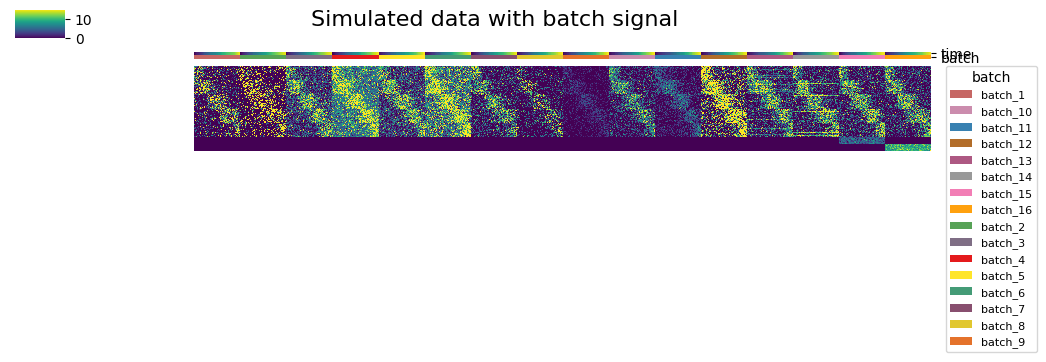

In [41]:
#ccd.pl.heatmap_with_annotations(adata_state, val='no_noise', obs_keys=[state_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='True state', save_path=save_dir/f'true_state_heatmap_{file_suffix}.png', figsize=(6, 4), dpi=300)
#ccd.pl.heatmap_with_annotations(adata_state, val='wt_noise', obs_keys=[state_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='True state with noise', save_path=save_dir/f'true_state_with_noise_heatmap_{file_suffix}.png', figsize=(6, 4), dpi=300)
ccd.pl.heatmap_with_annotations(adata, val='X', vmax=15, obs_keys=[state_key, batch_key], pal=pal , yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Simulated data with batch signal', save_path=save_dir/f'simulated_data_heatmap_{file_suffix}.svg', figsize=(10, 1.6), add_color_legend=True, dpi=300)

## Integration pipeline

In [42]:
run_methods = concord_methods + other_methods
latent_dim = 30

In [46]:
# Add ground truth
ccd.ul.run_pca(adata_state, source_key='no_noise', result_key='no_noise_PCA', n_pc=latent_dim, random_state=seed)
ccd.ul.run_pca(adata_state, source_key='wt_noise', result_key='wt_noise_PCA', n_pc=latent_dim, random_state=seed)
# Put the PCA result in the adata object, so only one object is needed
adata.obsm['no_noise'] = adata.obsm['no_noise_PCA'] = adata_state.obsm['no_noise_PCA']
adata.obsm['wt_noise'] = adata.obsm['wt_noise_PCA'] = adata_state.obsm['wt_noise_PCA']

In [43]:
concord_kwargs = {
    'batch_size': 32,
    'n_epochs': 20,
    'load_data_into_memory': True,
    'verbose': False,
}
profile_logs = ccd.bm.run_integration_methods_pipeline(
    adata=adata,                          # Your input AnnData object
    methods=run_methods,            # List of methods to run
    batch_key=batch_key,                    # Column in adata.obs for batch info
    count_layer="counts",                 # Layer name containing raw counts
    class_key=state_key,               # Column in adata.obs for class labels (used in SCANVI and CONCORD variants)
    latent_dim=latent_dim,                        # Latent dimensionality for PCA and embeddings
    device="cpu",                        # Or "cpu", or "mps" for Apple Silicon
    return_corrected=False,                   # Whether to store corrected expression matrices
    transform_batch=None,                 # Optionally specify a batch to transform to in scVI
    seed=seed,                              # Random seed for reproducibility
    compute_umap=False,                        # Run UMAP for all output embeddings
    umap_n_components=2,
    umap_n_neighbors=30,
    umap_min_dist=0.5,
    verbose=True,                        # Print progress messages
    concord_kwargs=concord_kwargs,          # Additional kwargs for CONCORD
)


concord - WARNING - save_dir is None. Model and log files will not be saved.
concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Epoch 0 Training
Epoch 1 Training
concord - WARNING - FAISS not found. Using sklearn for k-NN computation.
Epoch 2 Training
Epoch 3 Training
Epoch 4 Training
Epoch 5 Training
Epoch 6 Training
Epoch 7 Training
Epoch 8 Training
Epoch 9 Training
Epoch 10 Training
Epoch 11 Training
Epoch 12 Training
Epoch 13 Training
Epoch 14 Training
Epoch 15 Training
Epoch 16 Training
Epoch 17 Training
Epoch 18 Training
Epoch 19 Training
concord - WARNING - save_dir is None. Skipping model/config saving.


concord_knn: 16.75s | 0.22 MB RAM | 0.00 MB VRAM


concord - WARNING - save_dir is None. Model and log files will not be saved.
concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Epoch 0 Training
Epoch 1 Training
Epoch 2 Training
Epoch 3 Training
Epoch 4 Training
Epoch 5 Training
Epoch 6 Training
Epoch 7 Training
Epoch 8 Training
Epoch 9 Training
Epoch 10 Training
Epoch 11 Training
Epoch 12 Training
Epoch 13 Training
Epoch 14 Training
Epoch 15 Training
Epoch 16 Training
Epoch 17 Training
Epoch 18 Training
Epoch 19 Training
concord - WARNING - save_dir is None. Skipping model/config saving.


concord_hcl: 16.18s | 0.05 MB RAM | 0.00 MB VRAM


concord - WARNING - save_dir is None. Model and log files will not be saved.
concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
concord - WARNING - domain/batch information not found, all samples will be treated as from single domain/batch.
concord - WARNING - Only one domain found in the data. Setting p_intra_domain to 1.0.
Epoch 0 Training
Epoch 1 Training
Epoch 2 Training
Epoch 3 Training
Epoch 4 Training
Epoch 5 Training
Epoch 6 Training
Epoch 7 Training
Epoch 8 Training
Epoch 9 Training
Epoch 10 Training
Epoch 11 Training
Epoch 12 Training
Epoch 13 Training
Epoch 14 Training
Epoch 15 Training
Epoch 16 Training
Epoch 17 Training
Epoch 18 Training
Epoch 19 Training
concord - WARNING - save_dir is None. Skippin

contrastive: 14.93s | 0.03 MB RAM | 0.00 MB VRAM
Running PCA for 'unintegrated' embedding …


Found 2400 genes among all datasets


scanorama: 0.80s | 3.39 MB RAM | 0.00 MB VRAM


[[0.    0.004 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    

100%|██████████| 30/30 [03:05<00:00,  6.18s/it]
liger: 186.52s | 309.73 MB RAM | 0.00 MB VRAM


	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).


harmony: 4.44s | 0.11 MB RAM | 0.00 MB VRAM


	Completed 8 / 10 iteration(s).
Reach convergence after 8 iteration(s).


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.
scvi: 219.91s | 0.05 MB RAM | 0.00 MB VRAM
✅ All selected methods completed.


In [47]:
for basis in combined_keys:
    if basis not in adata.obsm:
        print(f"Warning: {basis} not found in adata.obsm. Skipping UMAP for this basis.")
        continue
    if 'PCA' not in basis:
        n_pc = min(adata.obsm[basis].shape[1], adata.shape[0]) - 1
        ccd.ul.run_pca(adata, source_key=basis, result_key=f'{basis}_PCA', n_pc=n_pc, random_state=seed)
    print("Running UMAP for", basis)
    ccd.ul.run_umap(adata, source_key=basis, result_key=f'{basis}_UMAP', n_components=2, n_neighbors=30, min_dist=0.3, metric='euclidean', random_state=seed)

Running UMAP for no_noise
Running UMAP for wt_noise
Running UMAP for concord_hcl
Running UMAP for concord_knn
Running UMAP for contrastive
Running UMAP for unintegrated
Running UMAP for scanorama
Running UMAP for liger
Running UMAP for harmony
Running UMAP for scvi


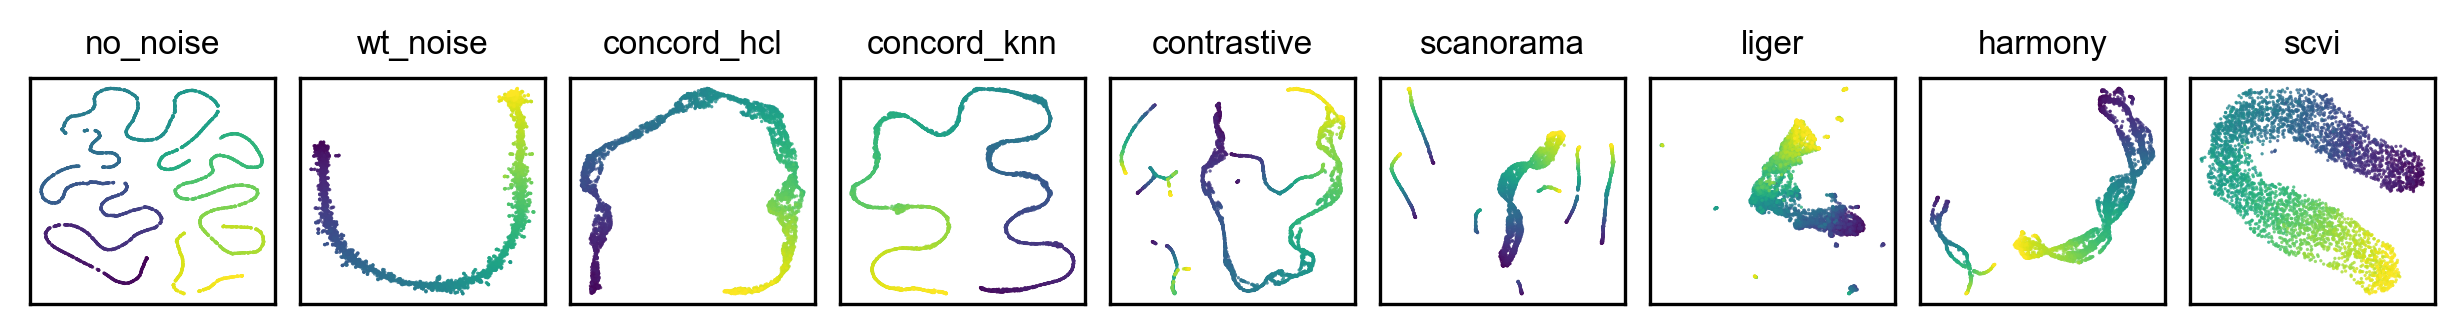

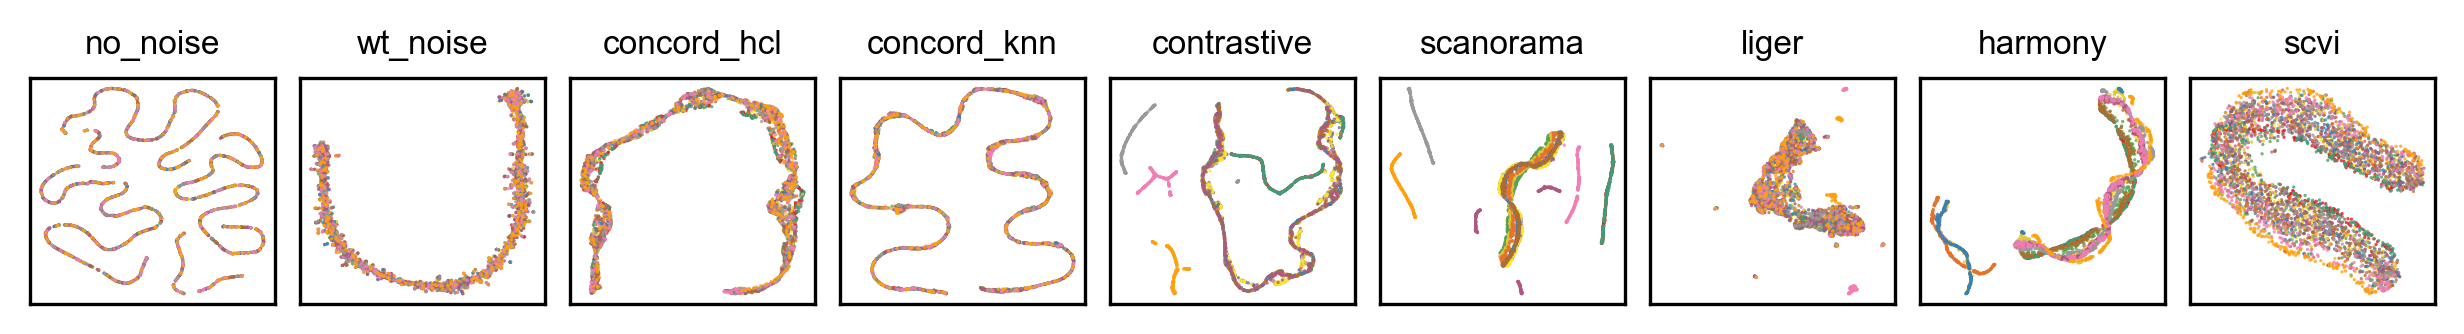

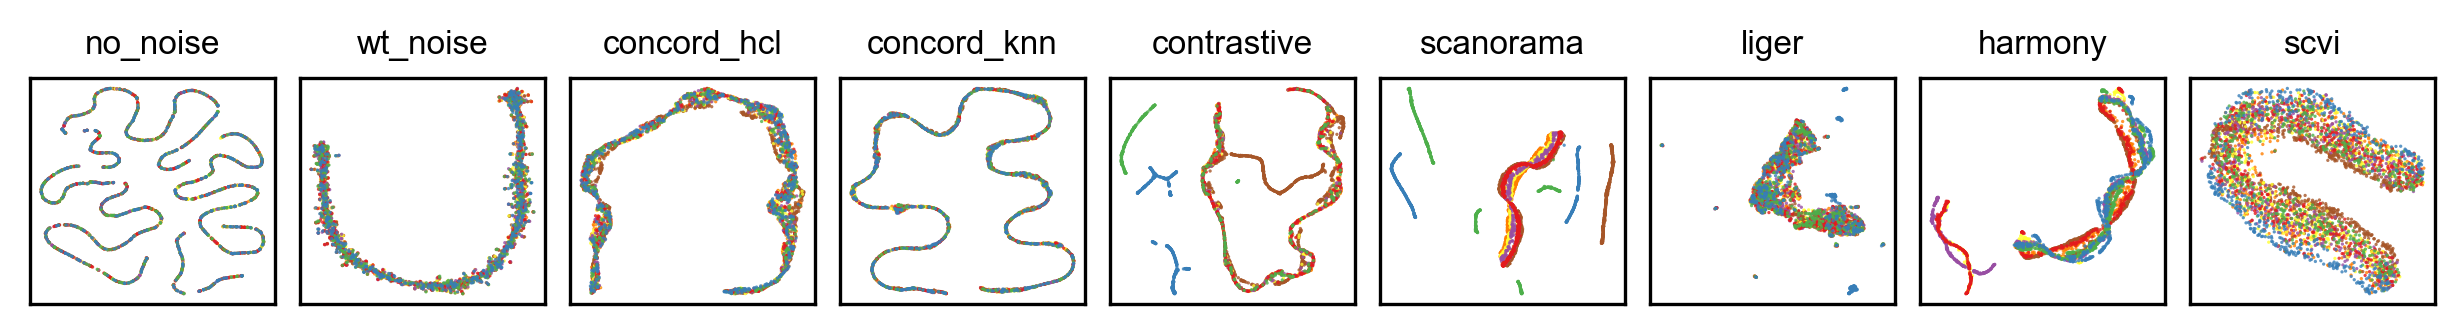

In [49]:
# plot everything
import matplotlib.pyplot as plt

show_keys = [key for key in combined_keys if key != 'unintegrated']
# check which methods are run successfully
adata.obs['time'] = adata.obs['time'].astype(float)
color_bys = ['time', 'batch', 'batch_type']
basis_types = ['UMAP']
#basis_types = ['PCA']
font_size=8
point_size=2.5
alpha=0.8
figsize=(0.9*len(show_keys),1)
ncols = len(show_keys)
nrows = int(np.ceil(len(show_keys) / ncols))
k=15
edges_color='grey'
edges_width=0
layout='kk'
threshold = 0.1
node_size_scale=0.1
edge_width_scale=0.1

rasterized = True
with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata,
        show_keys,
        color_bys=color_bys,
        basis_types=basis_types,
        pal=pal,
        k=k,
        edges_color=edges_color,
        edges_width=edges_width,
        layout=layout,
        threshold=threshold,
        node_size_scale=node_size_scale,
        edge_width_scale=edge_width_scale,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        rasterized=rasterized,
        figsize=figsize,
        ncols=ncols,
        seed=seed,
        leiden_key='leiden',
        save_dir=save_dir,
        legend_loc = None,
        file_suffix=file_suffix+f'rasterized_{rasterized}',
        save_format='svg'
    )


In [58]:
# Find the indices of common genes between `adata` and `adata_state`
# sort and smooth the signal along the path
batch_id=adata.obs['batch'].unique()[0]
batch_indices = np.where(adata.obs['batch'] == batch_id)[0]
_, _, _, feature_order = ccd.ul.sort_and_smooth_signal_along_path(adata, signal_key='concord_knn', path=batch_indices, sigma=2)
adata.obsm['concord_knn_sorted'] = adata.obsm['concord_knn'][:, feature_order]
_, _, _, feature_order = ccd.ul.sort_and_smooth_signal_along_path(adata, signal_key='concord_hcl', path=batch_indices, sigma=2)
adata.obsm['concord_hcl_sorted'] = adata.obsm['concord_hcl'][:, feature_order]

_, _, _, feature_order = ccd.ul.sort_and_smooth_signal_along_path(adata, signal_key='scvi', path=batch_indices, sigma=2)
adata.obsm['scvi_sorted'] = adata.obsm['scvi'][:, feature_order]


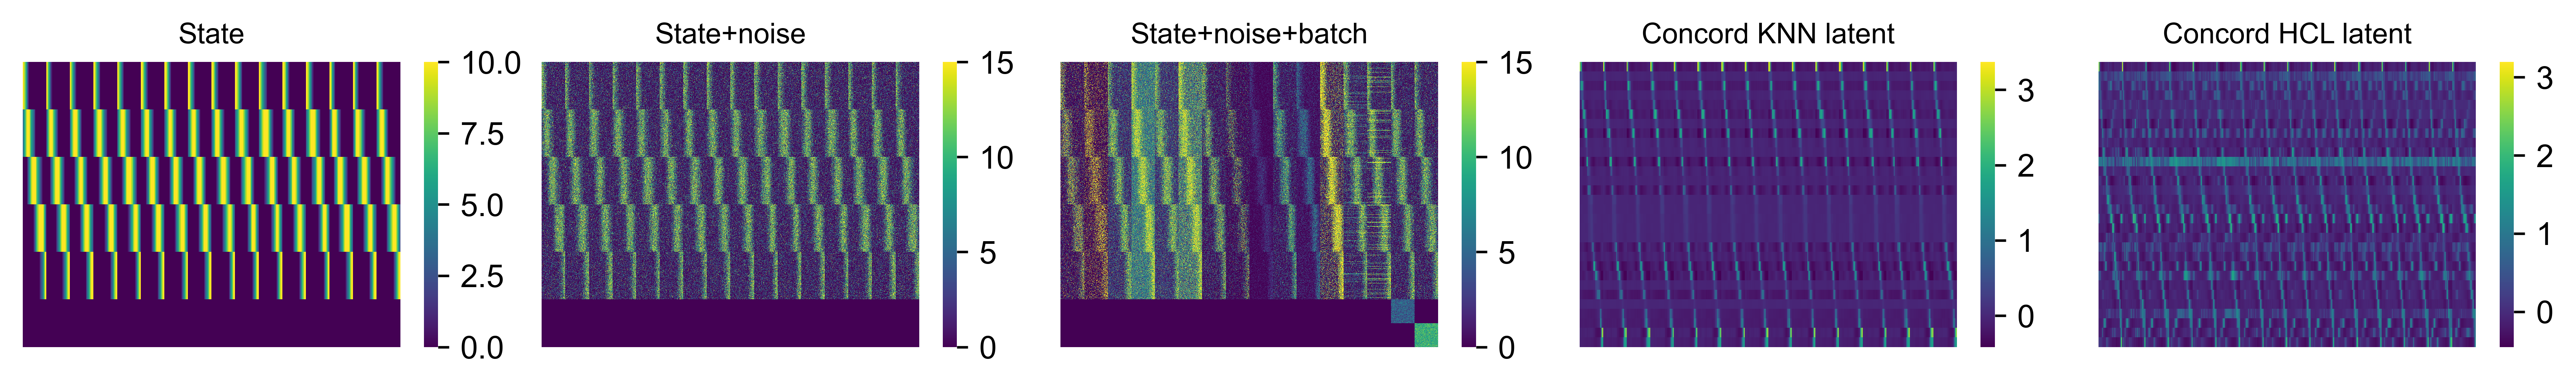

In [60]:
# Plot heatmap of original data and Concord latent
import matplotlib.pyplot as plt
figsize = (2.3, 1.8)
ncols = 5
title_fontsize = 9
_, _, state_pal = ccd.pl.get_color_mapping(adata, state_key, pal='Paired', seed=seed)
_, _, batch_pal = ccd.pl.get_color_mapping(adata, batch_key, pal='Set1', seed=seed)
pal = {state_key: state_pal, batch_key: batch_pal}
dpi = 600
with plt.rc_context(rc=custom_rc):
    fig, axes = plt.subplots(1, ncols, figsize=(figsize[0] * ncols, figsize[1]), dpi=dpi)
    ccd.pl.heatmap_with_annotations(adata, val='no_noise', obs_keys=[state_key], ax = axes[0], use_clustermap=False, pal=pal, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
    ccd.pl.heatmap_with_annotations(adata, val='wt_noise', vmax=15, obs_keys=[state_key], ax = axes[1], use_clustermap=False, pal=pal, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State+noise', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
    ccd.pl.heatmap_with_annotations(adata, val='X', vmax=15, obs_keys=[state_key, batch_key], ax = axes[2], use_clustermap=False, pal=pal, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State+noise+batch', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
    ccd.pl.heatmap_with_annotations(adata, val='concord_knn_sorted', obs_keys=[state_key, batch_key], ax = axes[3], use_clustermap=False, pal=pal, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Concord KNN latent', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
    ccd.pl.heatmap_with_annotations(adata, val='concord_hcl_sorted', obs_keys=[state_key, batch_key], ax = axes[4], use_clustermap=False, pal=pal, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Concord HCL latent', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
    plt.tight_layout(w_pad=0.0, h_pad=0.1)
    plt.savefig(save_dir / f"all_heatmaps_{file_suffix}.svg", dpi=dpi, bbox_inches='tight')

In [52]:
# Save result
adata.write_h5ad(data_dir / f"adata_{file_suffix}.h5ad", compression='gzip')
adata_state.write_h5ad(data_dir / f"adata_state_{file_suffix}.h5ad", compression='gzip')
print(f"Saved adata to {data_dir / f'adata_{file_suffix}.h5ad'}")
print(f"Saved adata_state to {data_dir / f'adata_state_{file_suffix}.h5ad'}")

Saved adata to ../data/simulation_trajectory_varybatch/adata_Jul29-2018.h5ad
Saved adata_state to ../data/simulation_trajectory_varybatch/adata_state_Jul29-2018.h5ad


### Benchmark

In [ ]:
adata = sc.read(data_dir / f"adata_Jul29-2018.h5ad")
adata_state = sc.read(data_dir / f"adata_state_Jul29-2018.h5ad")

In [53]:
# Generate Leiden clusters for the clean state data as pseudo labels
leiden_key = 'leiden_no_noise'
sc.pp.neighbors(adata_state, use_rep='no_noise_PCA', n_neighbors=30, random_state=seed)
sc.tl.leiden(adata_state, resolution=1.0, key_added=leiden_key, random_state=seed)
adata.obs[leiden_key] = adata_state.obs[leiden_key]

concord - INFO - Running SCIB benchmark


Embeddings: 100%|██████████| 10/10 [00:44<00:00,  4.45s/it]


concord - INFO - Running Probe benchmark
Detected task: classification
[KNN] detected task: classification
concord - INFO - Computing cell distance correlation
concord - INFO - Computing trustworthiness
concord - INFO - Computing state dispersion correlation
concord - INFO - Saved full geometry benchmark results to ../save/dev_simulation_trajectory_varybatch-Jul29/benchmarks_out/geometry_results_Jul29-2018.pkl


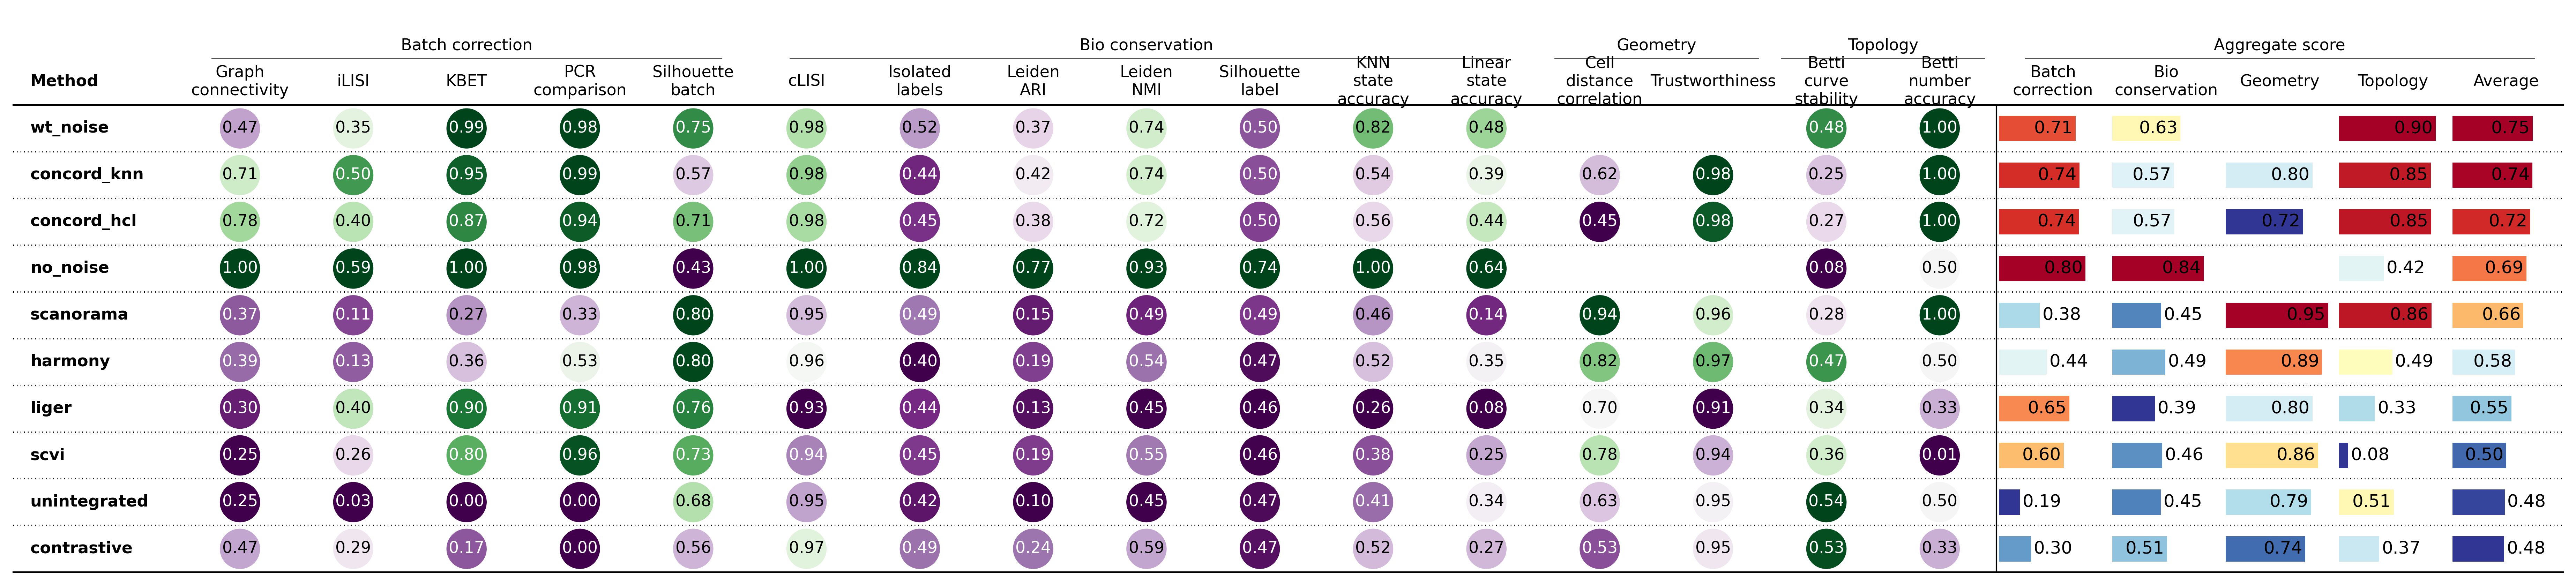

concord - INFO - Saved benchmark results to ../save/dev_simulation_trajectory_varybatch-Jul29/benchmarks_out/benchmark_results_Jul29-2018.pkl


Batch correction                                     \
            Graph connectivity     iLISI      KBET PCR comparison   
wt_noise              0.467592   0.35021  0.993995       0.984608   
concord_knn           0.714252  0.503244  0.946126       0.987194   
concord_hcl           0.777027  0.402891  0.867812       0.939775   
no_noise                   1.0  0.594448  0.997468       0.983714   
scanorama             0.374707  0.111139  0.271632       0.330583   

                             Bio conservation                             \
            Silhouette batch            cLISI Isolated labels Leiden ARI   
wt_noise            0.749494         0.975758        0.524449   0.369511   
concord_knn         0.571382         0.979336        0.439905   0.415232   
concord_hcl          0.71283         0.977021         0.44825    0.38141   
no_noise            0.432876         0.999373        0.839897   0.771831   
scanorama            0.80088         0.951878        0.494686   0.147785   

                                         ...                        \
            Leiden NMI Silhouette label  ... Linear state accuracy   
wt_noise       0.74207         0.504661  ...               0.47625   
concord_knn   0.740329         0.502815  ...               0.38500   
concord_hcl   0.721511         0.496983  ...               0.43625   
no_noise      0.927697         0.743614  ...               0.63500   
scanorama     0.485861         0.492319  ...               0.13750   

                             Geometry                              Topology  \
            Cell distance correlation Trustworthiness Betti curve stability   
wt_noise                          NaN             NaN              0.475019   
concord_knn                  0.624025        0.984908              0.247425   
concord_hcl                  0.452312        0.981790              0.269789   
no_noise                          NaN             NaN              0.079061   
scanorama                    0.941419        0.957547              0.283058   

                                   Aggregate score                             \
            Betti number accuracy Batch correction Bio conservation  Geometry   
wt_noise                      1.0         0.709180         0.630921       NaN   
concord_knn                   1.0         0.744440         0.571802  0.804467   
concord_hcl                   1.0         0.740067         0.574846  0.717051   
no_noise                      0.5         0.801701         0.844809       NaN   
scanorama                     1.0         0.377788         0.452683  0.949483   

                                 
             Topology   Average  
wt_noise     0.895004  0.745035  
concord_knn  0.849485  0.742548  
concord_hcl  0.853958  0.721481  
no_noise     0.415812  0.687441  
scanorama    0.856612  0.659141  

[5 rows x 21 columns]

In [54]:
out = ccd.bm.run_benchmark_pipeline(
    adata,
    embedding_keys=combined_keys,
    state_key=leiden_key,
    batch_key=batch_key,
    groundtruth_key="no_noise",  # use the Leiden clusters as ground truth
    save_dir=save_dir / "benchmarks_out",
    file_suffix=file_suffix,  # e.g. "2025-06-25"
    run=("scib", "probe", "geometry", "topology"),          # run only these blocks
    plot_individual=False,          # skip the intermediate PDFs
    expected_betti_numbers=[0,0,0],  # expected Betti numbers for the geometry and topology blocks
    max_points=1000,
    verbose=True,
    seed=seed,  # for reproducibility
)
combined = out["combined"]
combined.head()

In [55]:
import pickle
out = pickle.load(open(Path("../save/dev_simulation_trajectory_varybatch-Jul29/benchmarks_out") / f"benchmark_results_Jul29-2018.pkl", "rb"))
combined = out["combined"]

with open('../save/dev_simulation_trajectory_varybatch-Jul29/benchmarks_out/topology_diagrams_Jul29-2018.pkl', 'rb') as f:
    diagrams = pickle.load(f)

geometry_full = pickle.load(open(Path("../save/dev_simulation_trajectory_varybatch-Jul29/benchmarks_out/geometry_results_Jul29-2018.pkl"), "rb"))


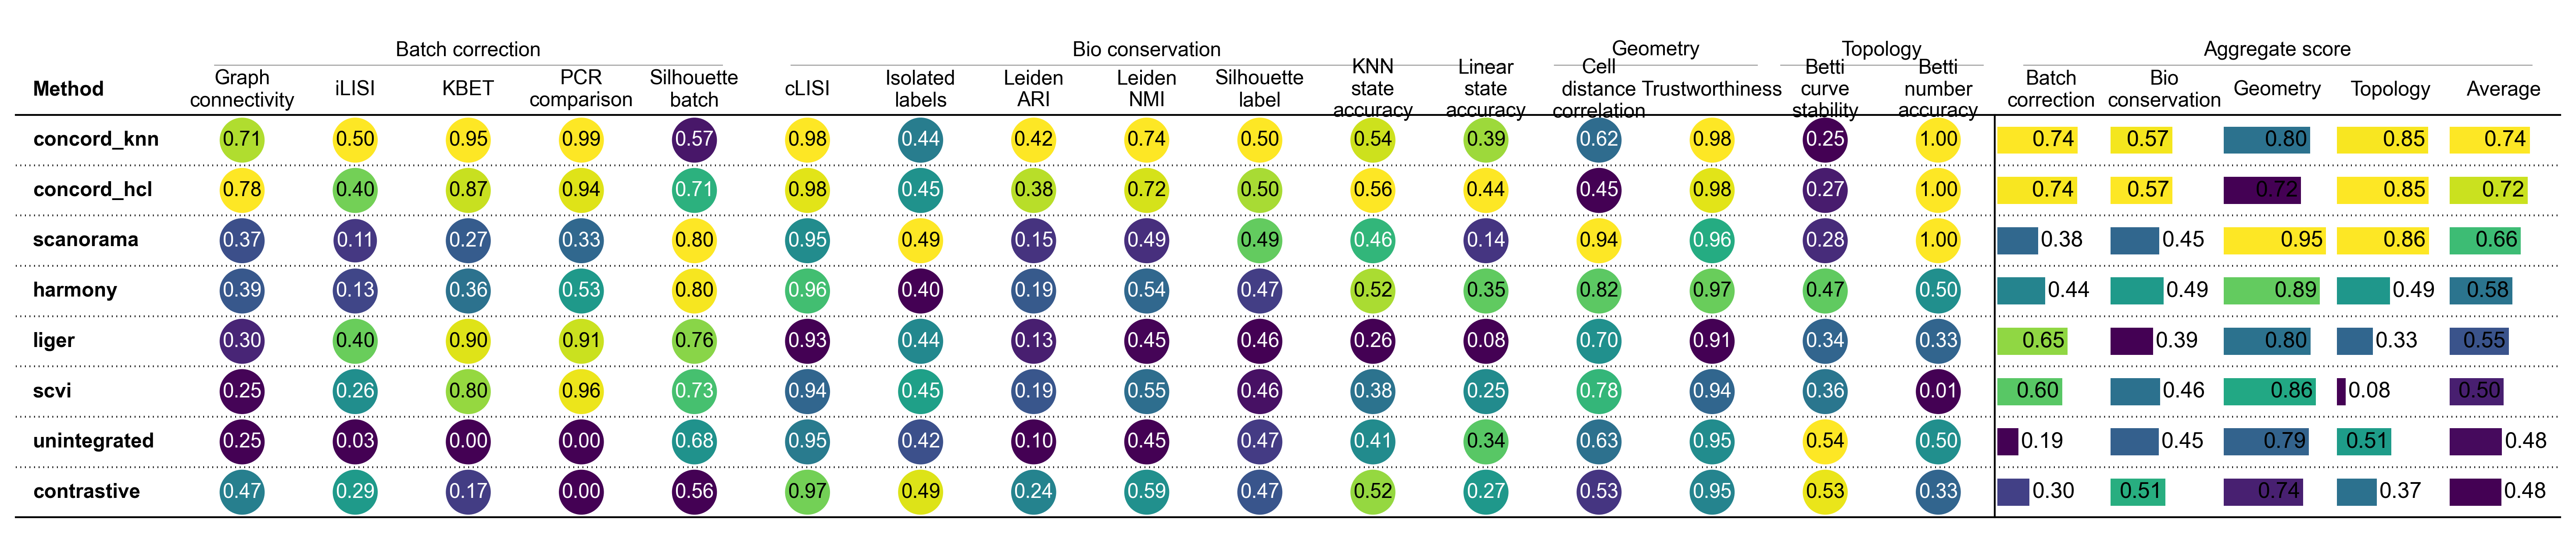

In [69]:
import pickle
table_plot_kw = dict(
        pal="viridis", pal_agg="viridis", cmap_method="minmax", dpi=300)
with plt.rc_context(rc=custom_rc):
    combined_df = ccd.bm.combine_benchmark_results(
        out,
        block_include=("geometry", "topology", "scib", "probe"),
        plot=False,
        save_path=save_dir / f"combined_res_{file_suffix}.pdf",
        table_plot_kw=table_plot_kw,
    )
    # Drop row with index 'unintegrated' and 'no_noise', 'wt_noise' from the combined_df
    combined_df = combined_df.drop(index=['no_noise', 'wt_noise'], errors='ignore')
    ccd.bm.plot_benchmark_table(
            combined_df.dropna(axis=0, how='any'),
            save_path=save_dir / f"benchmark_table_{file_suffix}.svg",
            agg_name="Aggregate score",
            figsize=(25, 5),
            **table_plot_kw
            )

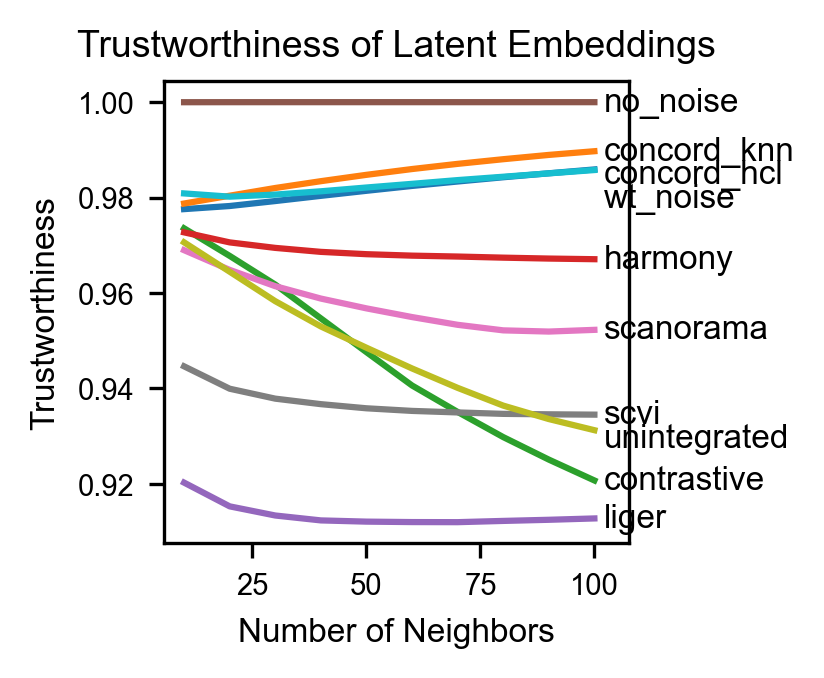

In [72]:
trustworthiness_scores = geometry_full['trustworthiness']['scores']
with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_trustworthiness(trustworthiness_scores, text_shift=2, min_gap=0.005, legend=False, save_path=save_dir / f"trustworthiness_{file_suffix}.pdf", figsize=(2,2))

### Performance on unseen batch effects

In [ ]:
adata = sc.read(data_dir / f"adata_Jul29-2018.h5ad")
adata_state = sc.read(data_dir / f"adata_state_Jul29-2018.h5ad")

In [61]:
adata.obsm

AxisArrays with keys: X_concord_warmup, concord_knn, concord_hcl, contrastive, X_pca, unintegrated, scanorama, liger, harmony, scvi, concord_hcl_PCA, concord_hcl_UMAP, concord_knn_PCA, concord_knn_UMAP, contrastive_PCA, contrastive_UMAP, unintegrated_PCA, unintegrated_UMAP, scanorama_PCA, scanorama_UMAP, liger_PCA, liger_UMAP, harmony_PCA, harmony_UMAP, scvi_PCA, scvi_UMAP, no_noise, no_noise_PCA, wt_noise, wt_noise_PCA, no_noise_UMAP, wt_noise_UMAP, concord_knn_sorted, concord_hcl_sorted, scvi_sorted

In [62]:
import itertools, random, pathlib, pandas as pd, numpy as np, scanpy as sc

# ----- experiment knobs ------------------------------------------------
BATCH_KEY      = "batch"
LEIDEN_KEY     = "leiden_no_noise"
MAX_R          = 5               # replicates per k
SAVE_DIR       = save_dir / "model_ckpts"
SAVE_DIR.mkdir(exist_ok=True, parents=True)
LATENT_DIM    = 30


def train_concord(adata_train, *, out_key, model_dir, mode, seed):
    concord_kwargs = {
        'batch_size': 32,
        'n_epochs': 20,
        'load_data_into_memory': True,
        'verbose': False,
    }
    if mode == 'hcl':
        concord_kwargs.update({
            'clr_beta': 1.0,
            'p_intra_knn': 0.0,
        })
    elif mode == 'knn':
        concord_kwargs.update({
            'clr_beta': 0.0,
            'p_intra_knn': 0.3,
        })
    else:
        raise ValueError(f"Unknown mode: {mode}")

    model = ccd.Concord(
        adata=adata_train, 
        latent_dim=LATENT_DIM,  # specify latent dimension
        domain_key=BATCH_KEY,
        seed=seed, save_dir=model_dir, 
        **concord_kwargs
    )
    model.fit_transform(output_key=out_key)
    return model          # keep for .predict_adata()

def train_scvi_reference(adata_ref, *, model_dir, seed, latent_key="scvi_latent"):
    """
    Train an SCVI model on `adata_ref`, save it to `model_dir`,
    and write the reference latent to `adata_ref.obsm[latent_key]`.
    """
    import scvi
    scvi.model.SCVI.setup_anndata(adata_ref, batch_key=BATCH_KEY)
    vae = scvi.model.SCVI(adata_ref, n_latent=LATENT_DIM)
    vae.train()
    vae.save(model_dir, overwrite=True)                # <--- saves weights + registry
    adata_ref.obsm[latent_key] = vae.get_latent_representation()
    return model_dir   

def embed_scvi_query(adata_query, *, model_dir, latent_key="scvi_latent"):
    """
    Given trained model at `model_dir`, project `adata_query`
    into the same latent space and write to `adata_query.obsm[latent_key]`.
    """
    import scvi
    # 1) register the query AnnData with the reference registry
    scvi.model.SCVI.prepare_query_anndata(adata_query, str(model_dir))

    # 2) create a *new* model tied to that query AnnData
    vae_q = scvi.model.SCVI.load_query_data(adata_query, str(model_dir))
    vae_q.is_trained = True                             # skip further training

    # 3) obtain latent representation
    adata_query.obsm[latent_key] = vae_q.get_latent_representation()


# ----- outer loop ------------------------------------------------------
all_batches = sorted(adata.obs[BATCH_KEY].unique())
N      = len(all_batches)

for k in range(1, N, 3):                          # number of training batches
    subsets = list(itertools.combinations(all_batches, k))
    random.Random(0).shuffle(subsets)          # reproducible
    for rep, train_batches in enumerate(subsets[:MAX_R]):
        test_batches = [b for b in all_batches if b not in train_batches]

        # split AnnData
        mask_train = adata.obs[BATCH_KEY].isin(train_batches)
        ad_train   = adata[mask_train].copy()
        ad_test    = adata[~mask_train].copy()

        print(f"Running k={k}, rep={rep+1}/{len(subsets[:MAX_R])} "
              f"({len(train_batches)} train, {len(test_batches)} test batches)")

        # ---------- CONCORD hcl ------------------------------------------
        run_id = f"concord_hcl_k{k}_rep{rep}"
        print(f"Running CONCORD with run_id={run_id}")
        ckpt_dir = SAVE_DIR / run_id
        ckpt_dir.mkdir(parents=True, exist_ok=True)

        model_c  = train_concord(ad_train, out_key="concord_hcl", mode="hcl",
                                 model_dir=ckpt_dir, seed=10_000 * k + rep)
        model_c.predict_adata(ad_test, output_key="concord_hcl")

        ad_merge = ad_train.concatenate(ad_test, batch_key="train_test_set",
                                         index_unique=None)
        
        # Append the embeddings to the original AnnData
        ad_merge = ad_merge[adata.obs_names]  # ensure order matches
        adata.obsm[run_id] = ad_merge.obsm["concord_hcl"]

        # ---------- CONCORD knn ------------------------------------------
        run_id = f"concord_knn_k{k}_rep{rep}"
        print(f"Running CONCORD with run_id={run_id}")
        ckpt_dir = SAVE_DIR / run_id
        ckpt_dir.mkdir(parents=True, exist_ok=True)

        model_c  = train_concord(ad_train, out_key="concord_knn", mode="knn",
                                 model_dir=ckpt_dir, seed=10_000 * k + rep)
        model_c.predict_adata(ad_test, output_key="concord_knn")

        ad_merge = ad_train.concatenate(ad_test, batch_key="train_test_set",
                                         index_unique=None)
        
        # Append the embeddings to the original AnnData
        ad_merge = ad_merge[adata.obs_names]  # ensure order matches
        adata.obsm[run_id] = ad_merge.obsm["concord_knn"]

        # ---------- scVI ----------------------------------
        run_id     = f"scvi_k{k}_rep{rep}"
        model_dir  = SAVE_DIR / run_id
        model_dir.mkdir(exist_ok=True, parents=True)

        # train on reference batches
        train_scvi_reference(ad_train, model_dir=model_dir,
                             seed=10_000 * k + rep,
                             latent_key="scVI")

        # embed held‑out batches as query
        embed_scvi_query(ad_test, model_dir=model_dir,
                         latent_key="scVI")

        # merge & score
        ad_merge = ad_train.concatenate(ad_test, batch_key="train_test_set",
                                        index_unique=None)
        ad_merge = ad_merge[adata.obs_names]  # ensure order matches
        adata.obsm[run_id] = ad_merge.obsm["scVI"]

        adata.obs[f'Set_k{k}_rep{rep}'] = ad_merge.obs["train_test_set"]



Running k=1, rep=1/5 (1 train, 15 test batches)
Running CONCORD with run_id=concord_hcl_k1_rep0
concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
concord - WARNING - Only one domain found in the data. Setting p_intra_domain to 1.0.
Epoch 0 Training
Epoch 1 Training
Epoch 2 Training
Epoch 3 Training
Epoch 4 Training
Epoch 5 Training
Epoch 6 Training
Epoch 7 Training
Epoch 8 Training
Epoch 9 Training
Epoch 10 Training
Epoch 11 Training
Epoch 12 Training
Epoch 13 Training
Epoch 14 Training
Epoch 15 Training
Epoch 16 Training
Epoch 17 Training
Epoch 18 Training
Epoch 19 Training
concord - WARNING - domain/batch information not found, all samples will be treated as from single domain/batch.
concord - WARNING - Only o

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     File ../save/dev_simulation_trajectory_varybatch-Jul29/model_ckpts/scvi_k1_rep0/model.pt already          
         downloaded                                                                                                
INFO     Found 100.0% reference vars in query data.                                                                
INFO     File ../save/dev_simulation_trajectory_varybatch-Jul29/model_ckpts/scvi_k1_rep0/model.pt already          
         downloaded                                                                                                
Running k=1, rep=2/5 (1 train, 15 test batches)
Running CONCORD with run_id=concord_hcl_k1_rep1
concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     File ../save/dev_simulation_trajectory_varybatch-Jul29/model_ckpts/scvi_k1_rep1/model.pt already          
         downloaded                                                                                                
INFO     Found 100.0% reference vars in query data.                                                                
INFO     File ../save/dev_simulation_trajectory_varybatch-Jul29/model_ckpts/scvi_k1_rep1/model.pt already          
         downloaded                                                                                                
Running k=1, rep=3/5 (1 train, 15 test batches)
Running CONCORD with run_id=concord_hcl_k1_rep2
concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     File ../save/dev_simulation_trajectory_varybatch-Jul29/model_ckpts/scvi_k1_rep2/model.pt already          
         downloaded                                                                                                
INFO     Found 100.0% reference vars in query data.                                                                
INFO     File ../save/dev_simulation_trajectory_varybatch-Jul29/model_ckpts/scvi_k1_rep2/model.pt already          
         downloaded                                                                                                
Running k=1, rep=4/5 (1 train, 15 test batches)
Running CONCORD with run_id=concord_hcl_k1_rep3
concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     File ../save/dev_simulation_trajectory_varybatch-Jul29/model_ckpts/scvi_k1_rep3/model.pt already          
         downloaded                                                                                                
INFO     Found 100.0% reference vars in query data.                                                                
INFO     File ../save/dev_simulation_trajectory_varybatch-Jul29/model_ckpts/scvi_k1_rep3/model.pt already          
         downloaded                                                                                                
Running k=1, rep=5/5 (1 train, 15 test batches)
Running CONCORD with run_id=concord_hcl_k1_rep4
concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     File ../save/dev_simulation_trajectory_varybatch-Jul29/model_ckpts/scvi_k1_rep4/model.pt already          
         downloaded                                                                                                
INFO     Found 100.0% reference vars in query data.                                                                
INFO     File ../save/dev_simulation_trajectory_varybatch-Jul29/model_ckpts/scvi_k1_rep4/model.pt already          
         downloaded                                                                                                
Running k=4, rep=1/5 (4 train, 12 test batches)
Running CONCORD with run_id=concord_hcl_k4_rep0
concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     File ../save/dev_simulation_trajectory_varybatch-Jul29/model_ckpts/scvi_k4_rep0/model.pt already          
         downloaded                                                                                                
INFO     Found 100.0% reference vars in query data.                                                                
INFO     File ../save/dev_simulation_trajectory_varybatch-Jul29/model_ckpts/scvi_k4_rep0/model.pt already          
         downloaded                                                                                                
Running k=4, rep=2/5 (4 train, 12 test batches)
Running CONCORD with run_id=concord_hcl_k4_rep1
concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     File ../save/dev_simulation_trajectory_varybatch-Jul29/model_ckpts/scvi_k4_rep1/model.pt already          
         downloaded                                                                                                
INFO     Found 100.0% reference vars in query data.                                                                
INFO     File ../save/dev_simulation_trajectory_varybatch-Jul29/model_ckpts/scvi_k4_rep1/model.pt already          
         downloaded                                                                                                
Running k=4, rep=3/5 (4 train, 12 test batches)
Running CONCORD with run_id=concord_hcl_k4_rep2
concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     File ../save/dev_simulation_trajectory_varybatch-Jul29/model_ckpts/scvi_k4_rep2/model.pt already          
         downloaded                                                                                                
INFO     Found 100.0% reference vars in query data.                                                                
INFO     File ../save/dev_simulation_trajectory_varybatch-Jul29/model_ckpts/scvi_k4_rep2/model.pt already          
         downloaded                                                                                                
Running k=4, rep=4/5 (4 train, 12 test batches)
Running CONCORD with run_id=concord_hcl_k4_rep3
concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     File ../save/dev_simulation_trajectory_varybatch-Jul29/model_ckpts/scvi_k4_rep3/model.pt already          
         downloaded                                                                                                
INFO     Found 100.0% reference vars in query data.                                                                
INFO     File ../save/dev_simulation_trajectory_varybatch-Jul29/model_ckpts/scvi_k4_rep3/model.pt already          
         downloaded                                                                                                
Running k=4, rep=5/5 (4 train, 12 test batches)
Running CONCORD with run_id=concord_hcl_k4_rep4
concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     File ../save/dev_simulation_trajectory_varybatch-Jul29/model_ckpts/scvi_k4_rep4/model.pt already          
         downloaded                                                                                                
INFO     Found 100.0% reference vars in query data.                                                                
INFO     File ../save/dev_simulation_trajectory_varybatch-Jul29/model_ckpts/scvi_k4_rep4/model.pt already          
         downloaded                                                                                                
Running k=7, rep=1/5 (7 train, 9 test batches)
Running CONCORD with run_id=concord_hcl_k7_rep0
concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features(

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     File ../save/dev_simulation_trajectory_varybatch-Jul29/model_ckpts/scvi_k7_rep0/model.pt already          
         downloaded                                                                                                
INFO     Found 100.0% reference vars in query data.                                                                
INFO     File ../save/dev_simulation_trajectory_varybatch-Jul29/model_ckpts/scvi_k7_rep0/model.pt already          
         downloaded                                                                                                
Running k=7, rep=2/5 (7 train, 9 test batches)
Running CONCORD with run_id=concord_hcl_k7_rep1
concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features(

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     File ../save/dev_simulation_trajectory_varybatch-Jul29/model_ckpts/scvi_k7_rep1/model.pt already          
         downloaded                                                                                                
INFO     Found 100.0% reference vars in query data.                                                                
INFO     File ../save/dev_simulation_trajectory_varybatch-Jul29/model_ckpts/scvi_k7_rep1/model.pt already          
         downloaded                                                                                                
Running k=7, rep=3/5 (7 train, 9 test batches)
Running CONCORD with run_id=concord_hcl_k7_rep2
concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features(

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     File ../save/dev_simulation_trajectory_varybatch-Jul29/model_ckpts/scvi_k7_rep2/model.pt already          
         downloaded                                                                                                
INFO     Found 100.0% reference vars in query data.                                                                
INFO     File ../save/dev_simulation_trajectory_varybatch-Jul29/model_ckpts/scvi_k7_rep2/model.pt already          
         downloaded                                                                                                
Running k=7, rep=4/5 (7 train, 9 test batches)
Running CONCORD with run_id=concord_hcl_k7_rep3
concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features(

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     File ../save/dev_simulation_trajectory_varybatch-Jul29/model_ckpts/scvi_k7_rep3/model.pt already          
         downloaded                                                                                                
INFO     Found 100.0% reference vars in query data.                                                                
INFO     File ../save/dev_simulation_trajectory_varybatch-Jul29/model_ckpts/scvi_k7_rep3/model.pt already          
         downloaded                                                                                                
Running k=7, rep=5/5 (7 train, 9 test batches)
Running CONCORD with run_id=concord_hcl_k7_rep4
concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features(

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     File ../save/dev_simulation_trajectory_varybatch-Jul29/model_ckpts/scvi_k7_rep4/model.pt already          
         downloaded                                                                                                
INFO     Found 100.0% reference vars in query data.                                                                
INFO     File ../save/dev_simulation_trajectory_varybatch-Jul29/model_ckpts/scvi_k7_rep4/model.pt already          
         downloaded                                                                                                
Running k=10, rep=1/5 (10 train, 6 test batches)
Running CONCORD with run_id=concord_hcl_k10_rep0
concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_featur

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     File ../save/dev_simulation_trajectory_varybatch-Jul29/model_ckpts/scvi_k10_rep0/model.pt already         
         downloaded                                                                                                
INFO     Found 100.0% reference vars in query data.                                                                
INFO     File ../save/dev_simulation_trajectory_varybatch-Jul29/model_ckpts/scvi_k10_rep0/model.pt already         
         downloaded                                                                                                
Running k=10, rep=2/5 (10 train, 6 test batches)
Running CONCORD with run_id=concord_hcl_k10_rep1
concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_featur

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     File ../save/dev_simulation_trajectory_varybatch-Jul29/model_ckpts/scvi_k10_rep1/model.pt already         
         downloaded                                                                                                
INFO     Found 100.0% reference vars in query data.                                                                
INFO     File ../save/dev_simulation_trajectory_varybatch-Jul29/model_ckpts/scvi_k10_rep1/model.pt already         
         downloaded                                                                                                
Running k=10, rep=3/5 (10 train, 6 test batches)
Running CONCORD with run_id=concord_hcl_k10_rep2
concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_featur

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     File ../save/dev_simulation_trajectory_varybatch-Jul29/model_ckpts/scvi_k10_rep2/model.pt already         
         downloaded                                                                                                
INFO     Found 100.0% reference vars in query data.                                                                
INFO     File ../save/dev_simulation_trajectory_varybatch-Jul29/model_ckpts/scvi_k10_rep2/model.pt already         
         downloaded                                                                                                
Running k=10, rep=4/5 (10 train, 6 test batches)
Running CONCORD with run_id=concord_hcl_k10_rep3
concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_featur

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     File ../save/dev_simulation_trajectory_varybatch-Jul29/model_ckpts/scvi_k10_rep3/model.pt already         
         downloaded                                                                                                
INFO     Found 100.0% reference vars in query data.                                                                
INFO     File ../save/dev_simulation_trajectory_varybatch-Jul29/model_ckpts/scvi_k10_rep3/model.pt already         
         downloaded                                                                                                
Running k=10, rep=5/5 (10 train, 6 test batches)
Running CONCORD with run_id=concord_hcl_k10_rep4
concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_featur

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     File ../save/dev_simulation_trajectory_varybatch-Jul29/model_ckpts/scvi_k10_rep4/model.pt already         
         downloaded                                                                                                
INFO     Found 100.0% reference vars in query data.                                                                
INFO     File ../save/dev_simulation_trajectory_varybatch-Jul29/model_ckpts/scvi_k10_rep4/model.pt already         
         downloaded                                                                                                
Running k=13, rep=1/5 (13 train, 3 test batches)
Running CONCORD with run_id=concord_hcl_k13_rep0
concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_featur

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     File ../save/dev_simulation_trajectory_varybatch-Jul29/model_ckpts/scvi_k13_rep0/model.pt already         
         downloaded                                                                                                
INFO     Found 100.0% reference vars in query data.                                                                
INFO     File ../save/dev_simulation_trajectory_varybatch-Jul29/model_ckpts/scvi_k13_rep0/model.pt already         
         downloaded                                                                                                
Running k=13, rep=2/5 (13 train, 3 test batches)
Running CONCORD with run_id=concord_hcl_k13_rep1
concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_featur

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     File ../save/dev_simulation_trajectory_varybatch-Jul29/model_ckpts/scvi_k13_rep1/model.pt already         
         downloaded                                                                                                
INFO     Found 100.0% reference vars in query data.                                                                
INFO     File ../save/dev_simulation_trajectory_varybatch-Jul29/model_ckpts/scvi_k13_rep1/model.pt already         
         downloaded                                                                                                
Running k=13, rep=3/5 (13 train, 3 test batches)
Running CONCORD with run_id=concord_hcl_k13_rep2
concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_featur

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     File ../save/dev_simulation_trajectory_varybatch-Jul29/model_ckpts/scvi_k13_rep2/model.pt already         
         downloaded                                                                                                
INFO     Found 100.0% reference vars in query data.                                                                
INFO     File ../save/dev_simulation_trajectory_varybatch-Jul29/model_ckpts/scvi_k13_rep2/model.pt already         
         downloaded                                                                                                
Running k=13, rep=4/5 (13 train, 3 test batches)
Running CONCORD with run_id=concord_hcl_k13_rep3
concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_featur

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     File ../save/dev_simulation_trajectory_varybatch-Jul29/model_ckpts/scvi_k13_rep3/model.pt already         
         downloaded                                                                                                
INFO     Found 100.0% reference vars in query data.                                                                
INFO     File ../save/dev_simulation_trajectory_varybatch-Jul29/model_ckpts/scvi_k13_rep3/model.pt already         
         downloaded                                                                                                
Running k=13, rep=5/5 (13 train, 3 test batches)
Running CONCORD with run_id=concord_hcl_k13_rep4
concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_featur

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


INFO     File ../save/dev_simulation_trajectory_varybatch-Jul29/model_ckpts/scvi_k13_rep4/model.pt already         
         downloaded                                                                                                
INFO     Found 100.0% reference vars in query data.                                                                
INFO     File ../save/dev_simulation_trajectory_varybatch-Jul29/model_ckpts/scvi_k13_rep4/model.pt already         
         downloaded                                                                                                


In [79]:
# Get run ids from adata.obsm, any key that starts with 'concord_hcl_k' or 'scvi_k', but not contain 'UMAP' or 'PCA'
run_ids = [key for key in adata.obsm.keys() if (key.startswith('concord_hcl_k') or key.startswith('concord_knn_k') or key.startswith('scvi_k')) and 'UMAP' not in key and 'PCA' not in key]
bm_results = ccd.bm.run_probe_benchmark(
        adata, embedding_keys=run_ids, state_key=LEIDEN_KEY,
        batch_key=BATCH_KEY, plot=False, verbose=True,
    )

concord - INFO - Running linear probe for state with keys ['concord_hcl_k1_rep0', 'concord_knn_k1_rep0', 'scvi_k1_rep0', 'concord_hcl_k1_rep1', 'concord_knn_k1_rep1', 'scvi_k1_rep1', 'concord_hcl_k1_rep2', 'concord_knn_k1_rep2', 'scvi_k1_rep2', 'concord_hcl_k1_rep3', 'concord_knn_k1_rep3', 'scvi_k1_rep3', 'concord_hcl_k1_rep4', 'concord_knn_k1_rep4', 'scvi_k1_rep4', 'concord_hcl_k4_rep0', 'concord_knn_k4_rep0', 'scvi_k4_rep0', 'concord_hcl_k4_rep1', 'concord_knn_k4_rep1', 'scvi_k4_rep1', 'concord_hcl_k4_rep2', 'concord_knn_k4_rep2', 'scvi_k4_rep2', 'concord_hcl_k4_rep3', 'concord_knn_k4_rep3', 'scvi_k4_rep3', 'concord_hcl_k4_rep4', 'concord_knn_k4_rep4', 'scvi_k4_rep4', 'concord_hcl_k7_rep0', 'concord_knn_k7_rep0', 'scvi_k7_rep0', 'concord_hcl_k7_rep1', 'concord_knn_k7_rep1', 'scvi_k7_rep1', 'concord_hcl_k7_rep2', 'concord_knn_k7_rep2', 'scvi_k7_rep2', 'concord_hcl_k7_rep3', 'concord_knn_k7_rep3', 'scvi_k7_rep3', 'concord_hcl_k7_rep4', 'concord_knn_k7_rep4', 'scvi_k7_rep4', 'concord_hc

In [64]:
hcl_ids = [key for key in adata.obsm.keys() if (key.startswith('concord_hcl_k')) and 'UMAP' not in key and 'PCA' not in key]
knn_ids = [key for key in adata.obsm.keys() if (key.startswith('concord_knn_k')) and 'UMAP' not in key and 'PCA' not in key]
scvi_ids = [key for key in adata.obsm.keys() if (key.startswith('scvi_k')) and 'UMAP' not in key and 'PCA' not in key]

In [ ]:
for basis in run_ids:
    print("Running UMAP for", basis)
    ccd.ul.run_umap(adata, source_key=basis, result_key=f'{basis}_UMAP', n_components=2, n_neighbors=30, min_dist=0.3, metric='euclidean', random_state=seed)

Running UMAP for concord_knn_k1_rep0
concord - INFO - UMAP embedding stored in adata.obsm['concord_knn_k1_rep0_UMAP']
Running UMAP for concord_knn_k1_rep1
concord - INFO - UMAP embedding stored in adata.obsm['concord_knn_k1_rep1_UMAP']
Running UMAP for concord_knn_k1_rep2
concord - INFO - UMAP embedding stored in adata.obsm['concord_knn_k1_rep2_UMAP']
Running UMAP for concord_knn_k1_rep3
concord - INFO - UMAP embedding stored in adata.obsm['concord_knn_k1_rep3_UMAP']
Running UMAP for concord_knn_k1_rep4
concord - INFO - UMAP embedding stored in adata.obsm['concord_knn_k1_rep4_UMAP']
Running UMAP for concord_knn_k4_rep0
concord - INFO - UMAP embedding stored in adata.obsm['concord_knn_k4_rep0_UMAP']
Running UMAP for concord_knn_k4_rep1
concord - INFO - UMAP embedding stored in adata.obsm['concord_knn_k4_rep1_UMAP']
Running UMAP for concord_knn_k4_rep2
concord - INFO - UMAP embedding stored in adata.obsm['concord_knn_k4_rep2_UMAP']
Running UMAP for concord_knn_k4_rep3
concord - INFO - UM

In [77]:
adata.write_h5ad(data_dir / f"adata_{file_suffix}.h5ad", compression='gzip')
print(f"Saved adata to {data_dir / f'adata_{file_suffix}.h5ad'}")

Saved adata to ../data/simulation_trajectory_varybatch/adata_Jul29-2018.h5ad


In [ ]:
adata = sc.read(data_dir / f"adata_Jul29-2018.h5ad")

concord.plotting.pl_embedding - INFO - Plotting concord_hcl_k1_rep1 with time in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_hcl_k4_rep1 with time in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_hcl_k7_rep1 with time in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_hcl_k10_rep1 with time in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_hcl_k13_rep1 with time in UMAP


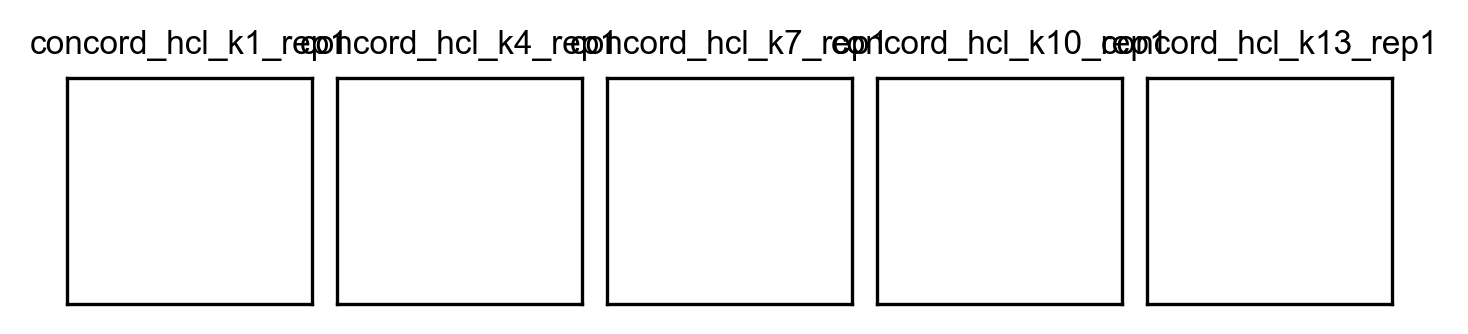

concord.plotting.pl_embedding - INFO - Plotting concord_hcl_k1_rep1 with batch in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_hcl_k4_rep1 with batch in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_hcl_k7_rep1 with batch in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_hcl_k10_rep1 with batch in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_hcl_k13_rep1 with batch in UMAP


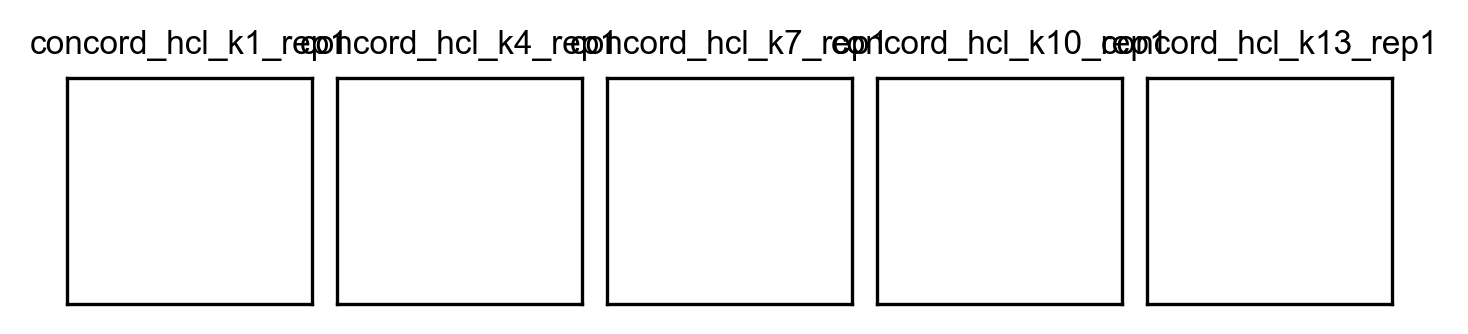

concord.plotting.pl_embedding - INFO - Plotting concord_hcl_k1_rep1 with batch_type in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_hcl_k4_rep1 with batch_type in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_hcl_k7_rep1 with batch_type in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_hcl_k10_rep1 with batch_type in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_hcl_k13_rep1 with batch_type in UMAP


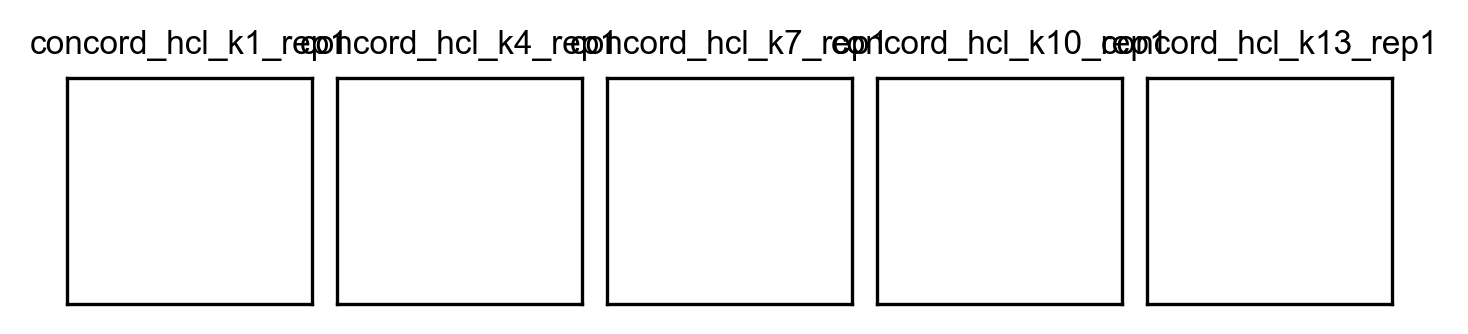

In [75]:
# plot everything
import matplotlib.pyplot as plt

show_keys = [key for key in hcl_ids if 'rep1' in key]
# check which methods are run successfully
adata.obs['time'] = adata.obs['time'].astype(float)
color_bys = ['time', 'batch', 'batch_type']
basis_types = ['UMAP']
#basis_types = ['PCA']
font_size=8
point_size=2.5
alpha=0.8
figsize=(0.9*len(show_keys),1)
ncols = len(show_keys)
nrows = int(np.ceil(len(show_keys) / ncols))
pal = {'time':'viridis', 'batch':'Set1', 'batch_type':'Set2'}
k=15
edges_color='grey'
edges_width=0
layout='kk'
threshold = 0.1
node_size_scale=0.1
edge_width_scale=0.1

rasterized = True
with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata,
        show_keys,
        color_bys=color_bys,
        basis_types=basis_types,
        pal=pal,
        k=k,
        edges_color=edges_color,
        edges_width=edges_width,
        layout=layout,
        threshold=threshold,
        node_size_scale=node_size_scale,
        edge_width_scale=edge_width_scale,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        rasterized=rasterized,
        figsize=figsize,
        ncols=ncols,
        seed=seed+2,
        leiden_key='leiden',
        save_dir=save_dir,
        legend_loc = 'on data',
        file_suffix=file_suffix+f'concord_hcl_results',
        save_format='svg'
    )


In [95]:
import re
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------------ #
# 0.  basic info                                                     #
# ------------------------------------------------------------------ #
BATCH_KEY        = "batch"                 # whatever you used earlier
total_batches    = adata.obs[BATCH_KEY].nunique()   # == N in the loop

# ------------------------------------------------------------------ #
# 1.  flatten the MultiIndex columns                                 #
# ------------------------------------------------------------------ #
flat = bm_results.copy()

flat.columns = (
    flat.columns.to_flat_index()           # e.g. ('KNN', 'batch\nerror')
        .map(lambda tup:
             "_".join(
                 str(x).strip().lower().replace("\n", " ")
                      .replace("  ", " ").replace(" ", "_")
                 for x in tup if x)        # drop empty level labels
        )
)

# after the call you'll have columns such as:
#   knn_batch_error, knn_state_accuracy,
#   linear_batch_error, linear_state_accuracy,
#   probe_state_accuracy, probe_score

# ------------------------------------------------------------------ #
# 2.  move run‑id (index) to a column & parse it                     #
# ------------------------------------------------------------------ #
flat = flat.reset_index().rename(columns={"Method": "run_id"})

# run_id pattern: <model>_k<k>_rep<rep>
m = flat["run_id"].str.extract(
        r"(?P<model>concord_hcl|concord_knn|scvi)_k(?P<k>\d+)_rep(?P<rep>\d+)"
    )
flat = pd.concat([flat, m.astype({"k": int, "rep": int})], axis=1)

# ------------------------------------------------------------------ #
# 3.  add training / held‑out info                                   #
# ------------------------------------------------------------------ #
flat["train_batches"] = flat["k"]
flat["test_batches"]  = total_batches - flat["k"]
flat["frac_dropped"]  = flat["test_batches"] / total_batches
flat['string_dropped'] = flat["test_batches"].astype(str) + "/" + str(total_batches)

In [92]:
flat["frac_dropped"].unique()

array([0.375 , 0.75  , 0.1875, 0.5625, 0.9375])

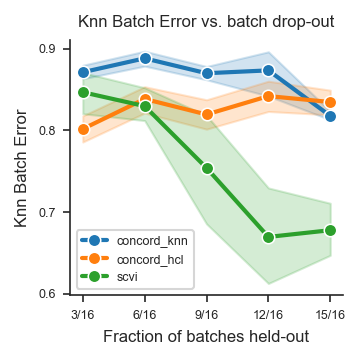

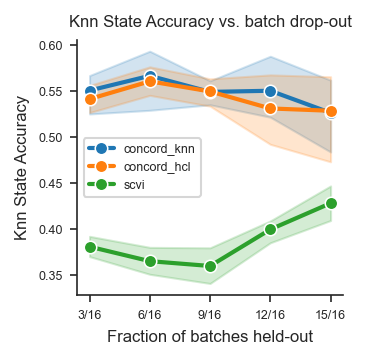

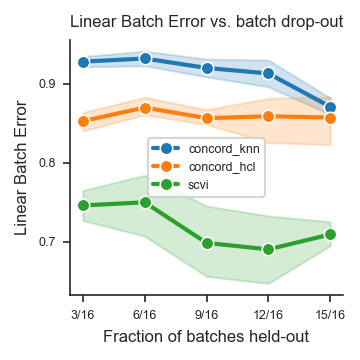

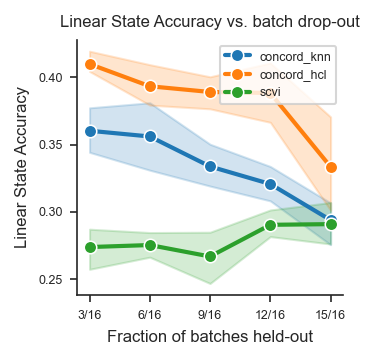

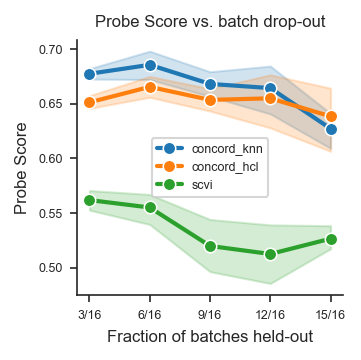

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("ticks")          # small aesthetic touch
# ------------------------------------------------------------------ #
# choose the columns you want; adjust if you renamed them differently
metrics = [
    "knn_batch_error", "knn_state_accuracy",
    "linear_batch_error", "linear_state_accuracy",
    "probe_score"
]

for metric in metrics:
    import seaborn as sns, matplotlib.pyplot as plt

    sns.set_style("ticks")
    with plt.rc_context(rc=custom_rc):
        plt.figure(figsize=(2.5,2.5), dpi=150)
        sns.lineplot(
            data=flat,
            x="frac_dropped", y=metric,
            hue="model",
            estimator="mean",   # or "median"
            ci=95,              # shaded ribbon
            marker="o", linewidth=2,
        )
        # Set x axis ticks to be unique values of frac_dropped
        # Set x axis ticks to be unique values of frac_dropped, but label with string_dropped
        unique_fracs = np.sort(flat["frac_dropped"].unique())
        # For each unique frac, get the first corresponding string_dropped
        frac_to_label = {frac: flat.loc[flat["frac_dropped"] == frac, "string_dropped"].iloc[0] for frac in unique_fracs}
        plt.xticks(
            unique_fracs,
            [frac_to_label[frac] for frac in unique_fracs]
        )

        # font size
        plt.xticks(fontsize=6)
        plt.yticks(fontsize=6)
        plt.legend(fontsize=6)
        plt.xlabel("Fraction of batches held-out", fontsize=8)
        plt.ylabel(metric.replace("_"," ").title(), fontsize=8)
        plt.title(f"{metric.replace('_',' ').title()} vs. batch drop-out", fontsize=8)
        sns.despine(); plt.tight_layout();
        plt.savefig(save_dir / f"{metric}_vs_batch_dropout_{file_suffix}.svg", dpi=300, bbox_inches='tight')



In [68]:
(0.78625     +    0.21375  +    0.80625     +    0.19375)/4

0.5

In [57]:
metrics

['batch_error', 'state_accuracy', 'probe_score']